In [1]:
import warnings
import itertools
import numpy as np
import verde as vd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import eqs_magnetics as eqs
import synthetics

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set the data coordinates and field direction.

N data: 92046


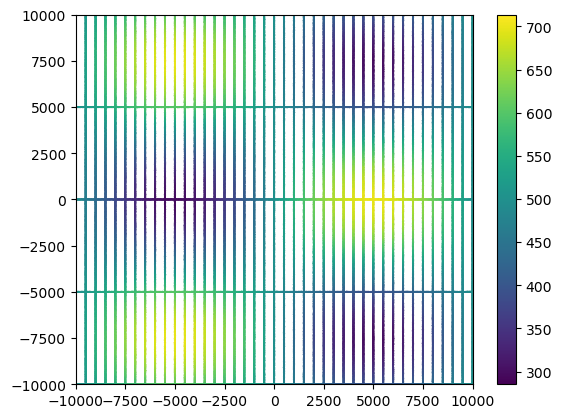

In [3]:
region = [-10e3, 10e3, -10e3, 10e3]
# Inc and dec from the IGRF around Antarctica
field_direction = eqs.angles_to_vector(inclination=84, declination=120, amplitude=1)
#field_direction = eqs.angles_to_vector(inclination=14, declination=122, amplitude=1)

# Generate fake flight lines
easting, northing = [c.ravel() for c in vd.grid_coordinates(region, spacing=(10, 500))]
easting_tie, northing_tie = [c.ravel() for c in vd.grid_coordinates(region, spacing=(5000, 10))]
easting = np.concatenate([easting, easting_tie])
northing = np.concatenate([northing, northing_tie])
upward = vd.synthetic.CheckerBoard(region=region, amplitude=200, w_east=20000, w_north=15000).predict((easting, northing)) + 500
coordinates = (easting, northing, upward)
for i, c in enumerate(coordinates):
    eqs.contaminate(c, standard_deviation=5, random_state=i)

print("N data:", coordinates[0].size)

plt.scatter(*coordinates[:2], c=coordinates[2], s=0.1)
plt.xlim(*region[:2])
plt.ylim(*region[2:])
plt.colorbar()

Create the dipole source model.

In [5]:
source_direction = [70, 90] # [inc, dec]
source_coordinates, dipole_moments = synthetics.simple_synthetic(
    dike1=source_direction,
    dike2=source_direction,
    point1=source_direction,
    point2=source_direction,
    point3=source_direction,
    point4=source_direction,
    regional=source_direction,
)

In [6]:
magnetic_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)
total_field_anomaly = eqs.contaminate(
    eqs.total_field_anomaly(magnetic_field, field_direction), standard_deviation=50, random_state=42,
)
bnorm = eqs.magnetic_field_norm(magnetic_field)

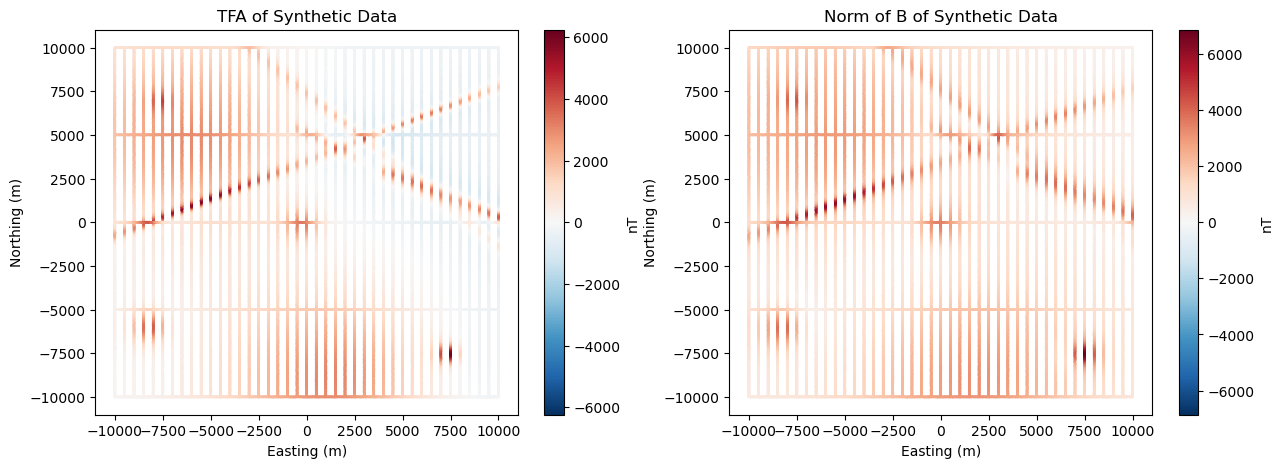

In [7]:
plt.figure(figsize=(15,5))
scale = vd.maxabs(total_field_anomaly)
#scale = 1000
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=total_field_anomaly, cmap="RdBu_r", s=0.5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="RdBu_r", s=0.5, vmin=-scale_bnorm, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()